In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import gzip
import sqlite3
import csv
import numpy as np
import seaborn as sns

In [2]:
# Originally I thought a simple .sort() method will turn my 'month' column into a usable format, 
# however, it could only sort from least to greatest in value format, meaning not Jan-Dec in calender order.
# This caused months axis to be confusing and hard to read/process.

# Thus, I had to create a new dataframe and split that dataframe into sub-dataframes in order to count the
# number of movies released per year, per month.
# Using these subdataframes, I was able to graph the last 6 months according to the avg worldwide gross income 
# as well as production budget for each month.

# Using this data, we should get a clear understanding of what other big movie companies are doing and prepare our team
# to do the same

In [3]:
# Load dataset 1 'bom.movie_gross' obtained from Box Office Mojo

df1 = pd.read_csv('data/zippedData/bom.movie_gross.csv.gz')
df1 = df1.rename(columns = {'title':'movie'})

In [4]:
# Load dataset 4 'imbd.title.basics' obtained from IMDB

df4 = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
df4 = df4.rename(columns = {'primary_title':'movie'})

In [5]:
# Load dataset 11 'tn.movie_budgets' from The-Numbers

df11 = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')

In [6]:
# Strip '$' and ',' from the dataset and convert to int64 in order to manipulate the data


df11['worldwide_gross'] = df11['worldwide_gross'].str[1:]
df11['worldwide_gross'] = df11['worldwide_gross'].str.replace(',', '').astype(np.int64)
df11['domestic_gross'] = df11['domestic_gross'].str[1:]
df11['domestic_gross'] = df11['domestic_gross'].str.replace(',', '').astype(np.int64)
df11['production_budget'] = df11['production_budget'].str[1:]
df11['production_budget'] = df11['production_budget'].str.replace(',', '').astype(np.int64)

# Filter the data to our criteria

production = df11[df11.production_budget < 1000000].index
df11.drop(production, inplace=True)
#domestic = df11[df11.domestic_gross < 1].index
#df11.drop(domestic, inplace=True)
worldwide = df11[df11.worldwide_gross < 1000000].index
df11.drop(worldwide, inplace=True)
df11.set_index('movie')

,id,release_date,production_budget,domestic_gross,worldwide_gross
movie,,,,,
Avatar,1,"Dec 18, 2009",425000000,760507625,2776345279
Pirates of the Caribbean: On Stranger Tides,2,"May 20, 2011",410600000,241063875,1045663875
Dark Phoenix,3,"Jun 7, 2019",350000000,42762350,149762350
Avengers: Age of Ultron,4,"May 1, 2015",330600000,459005868,1403013963
Star Wars Ep. VIII: The Last Jedi,5,"Dec 15, 2017",317000000,620181382,1316721747
...,...,...,...,...,...
Fiza,59,"Sep 8, 2000",1000000,623791,1179462
Ajami,60,"Feb 3, 2010",1000000,621859,2721096
The Future,62,"Jul 29, 2011",1000000,568662,1239174


In [7]:
# Merge the three dataframes together to get 'master' dataframe "BigFrame"

BigFrame = df11.merge(df1, on='movie').merge(df4, on='movie').drop(columns=['tconst', 'original_title', 'start_year', 'id', 'domestic_gross_y'])

In [8]:
BigFrame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482 entries, 0 to 1481
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       1482 non-null   object 
 1   movie              1482 non-null   object 
 2   production_budget  1482 non-null   int64  
 3   domestic_gross_x   1482 non-null   int64  
 4   worldwide_gross    1482 non-null   int64  
 5   studio             1482 non-null   object 
 6   foreign_gross      1327 non-null   object 
 7   year               1482 non-null   int64  
 8   runtime_minutes    1392 non-null   float64
 9   genres             1460 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 127.4+ KB


In [9]:
# Clean the data, remove duplicates, drop null values

BigFrame = BigFrame.drop_duplicates(subset='movie').set_index('movie')
BigFrame['month'] = BigFrame['release_date'].str[:3]

BigFrame = BigFrame.dropna()
BigFrame.dropna(inplace=True)

In [10]:
# Initialize list for eventual x-axis to use in graphs

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Create 6 new dataframes, one per year 2013-2018

df_2013 = BigFrame[BigFrame['year'] == 2013]
df_2014 = BigFrame[BigFrame['year'] == 2014]
df_2015 = BigFrame[BigFrame['year'] == 2015]
df_2016 = BigFrame[BigFrame['year'] == 2016]
df_2017 = BigFrame[BigFrame['year'] == 2017]
df_2018 = BigFrame[BigFrame['year'] == 2018]

In [11]:
# Create sub-dataframe from the year dataframe and get the average number of posts per month
# Repeat for each year

df_2013 = df_2013[['worldwide_gross', 'month', 'production_budget']]
df_2013 = df_2013.dropna(subset=['month'])
df_jan2013 = df_2013[df_2013['month'] == 'Jan'].mean().astype(np.int64)
df_feb2013 = df_2013[df_2013['month'] == 'Feb'].mean().astype(np.int64)
df_mar2013 = df_2013[df_2013['month'] == 'Mar'].mean().astype(np.int64)
df_apr2013 = df_2013[df_2013['month'] == 'Apr'].mean().astype(np.int64)
df_may2013 = df_2013[df_2013['month'] == 'May'].mean().astype(np.int64)
df_jun2013 = df_2013[df_2013['month'] == 'Jun'].mean().astype(np.int64)
df_jul2013 = df_2013[df_2013['month'] == 'Jul'].mean().astype(np.int64)
df_aug2013 = df_2013[df_2013['month'] == 'Aug'].mean().astype(np.int64)
df_sep2013 = df_2013[df_2013['month'] == 'Sep'].mean().astype(np.int64)
df_oct2013 = df_2013[df_2013['month'] == 'Oct'].mean().astype(np.int64)
df_nov2013 = df_2013[df_2013['month'] == 'Nov'].mean().astype(np.int64)
df_dec2013 = df_2013[df_2013['month'] == 'Dec'].mean().astype(np.int64)
df_2014 = df_2014[['worldwide_gross', 'month', 'production_budget']]
df_2014 = df_2014.dropna(subset=['month'])
df_jan2014 = df_2014[df_2014['month'] == 'Jan'].mean().astype(np.int64)
df_feb2014 = df_2014[df_2014['month'] == 'Feb'].mean().astype(np.int64)
df_mar2014 = df_2014[df_2014['month'] == 'Mar'].mean().astype(np.int64)
df_apr2014 = df_2014[df_2014['month'] == 'Apr'].mean().astype(np.int64)
df_may2014 = df_2014[df_2014['month'] == 'May'].mean().astype(np.int64)
df_jun2014 = df_2014[df_2014['month'] == 'Jun'].mean().astype(np.int64)
df_jul2014 = df_2014[df_2014['month'] == 'Jul'].mean().astype(np.int64)
df_aug2014 = df_2014[df_2014['month'] == 'Aug'].mean().astype(np.int64)
df_sep2014 = df_2014[df_2014['month'] == 'Sep'].mean().astype(np.int64)
df_oct2014 = df_2014[df_2014['month'] == 'Oct'].mean().astype(np.int64)
df_nov2014 = df_2014[df_2014['month'] == 'Nov'].mean().astype(np.int64)
df_dec2014 = df_2014[df_2014['month'] == 'Dec'].mean().astype(np.int64)

df_2015 = df_2015[['worldwide_gross', 'month', 'production_budget']]
df_2015 = df_2015.dropna(subset=['month'])
df_jan2015 = df_2015[df_2015['month'] == 'Jan'].mean().astype(np.int64)
df_feb2015 = df_2015[df_2015['month'] == 'Feb'].mean().astype(np.int64)
df_mar2015 = df_2015[df_2015['month'] == 'Mar'].mean().astype(np.int64)
df_apr2015 = df_2015[df_2015['month'] == 'Apr'].mean().astype(np.int64)
df_may2015 = df_2015[df_2015['month'] == 'May'].mean().astype(np.int64)
df_jun2015 = df_2015[df_2015['month'] == 'Jun'].mean().astype(np.int64)
df_jul2015 = df_2015[df_2015['month'] == 'Jul'].mean().astype(np.int64)
df_aug2015 = df_2015[df_2015['month'] == 'Aug'].mean().astype(np.int64)
df_sep2015 = df_2015[df_2015['month'] == 'Sep'].mean().astype(np.int64)
df_oct2015 = df_2015[df_2015['month'] == 'Oct'].mean().astype(np.int64)
df_nov2015 = df_2015[df_2015['month'] == 'Nov'].mean().astype(np.int64)
df_dec2015 = df_2015[df_2015['month'] == 'Dec'].mean().astype(np.int64)

df_2016 = df_2016[['worldwide_gross', 'month', 'production_budget']]
df_2016 = df_2016.dropna(subset=['month'])
df_jan2016 = df_2016[df_2016['month'] == 'Jan'].mean().astype(np.int64)
df_feb2016 = df_2016[df_2016['month'] == 'Feb'].mean().astype(np.int64)
df_mar2016 = df_2016[df_2016['month'] == 'Mar'].mean().astype(np.int64)
df_apr2016 = df_2016[df_2016['month'] == 'Apr'].mean().astype(np.int64)
df_may2016 = df_2016[df_2016['month'] == 'May'].mean().astype(np.int64)
df_jun2016 = df_2016[df_2016['month'] == 'Jun'].mean().astype(np.int64)
df_jul2016 = df_2016[df_2016['month'] == 'Jul'].mean().astype(np.int64)
df_aug2016 = df_2016[df_2016['month'] == 'Aug'].mean().astype(np.int64)
df_sep2016 = df_2016[df_2016['month'] == 'Sep'].mean().astype(np.int64)
df_oct2016 = df_2016[df_2016['month'] == 'Oct'].mean().astype(np.int64)
df_nov2016 = df_2016[df_2016['month'] == 'Nov'].mean().astype(np.int64)
df_dec2016 = df_2016[df_2016['month'] == 'Dec'].mean().astype(np.int64)

df_2017 = df_2017[['worldwide_gross', 'month', 'production_budget']]
df_2017 = df_2017.dropna(subset=['month'])
df_jan2017 = df_2017[df_2017['month'] == 'Jan'].mean().astype(np.int64)
df_feb2017 = df_2017[df_2017['month'] == 'Feb'].mean().astype(np.int64)
df_mar2017 = df_2017[df_2017['month'] == 'Mar'].mean().astype(np.int64)
df_apr2017 = df_2017[df_2017['month'] == 'Apr'].mean().astype(np.int64)
df_may2017 = df_2017[df_2017['month'] == 'May'].mean().astype(np.int64)
df_jun2017 = df_2017[df_2017['month'] == 'Jun'].mean().astype(np.int64)
df_jul2017 = df_2017[df_2017['month'] == 'Jul'].mean().astype(np.int64)
df_aug2017 = df_2017[df_2017['month'] == 'Aug'].mean().astype(np.int64)
df_sep2017 = df_2017[df_2017['month'] == 'Sep'].mean().astype(np.int64)
df_oct2017 = df_2017[df_2017['month'] == 'Oct'].mean().astype(np.int64)
df_nov2017 = df_2017[df_2017['month'] == 'Nov'].mean().astype(np.int64)
df_dec2017 = df_2017[df_2017['month'] == 'Dec'].mean().astype(np.int64)

df_2018 = df_2018[['worldwide_gross', 'month', 'production_budget']]
df_2018 = df_2018.dropna(subset=['month'])
df_jan2018 = df_2018[df_2018['month'] == 'Jan'].mean().astype(np.int64)
df_feb2018 = df_2018[df_2018['month'] == 'Feb'].mean().astype(np.int64)
df_mar2018 = df_2018[df_2018['month'] == 'Mar'].mean().astype(np.int64)
df_apr2018 = df_2018[df_2018['month'] == 'Apr'].mean().astype(np.int64)
df_may2018 = df_2018[df_2018['month'] == 'May'].mean().astype(np.int64)
df_jun2018 = df_2018[df_2018['month'] == 'Jun'].mean().astype(np.int64)
df_jul2018 = df_2018[df_2018['month'] == 'Jul'].mean().astype(np.int64)
df_aug2018 = df_2018[df_2018['month'] == 'Aug'].mean().astype(np.int64)
df_sep2018 = df_2018[df_2018['month'] == 'Sep'].mean().astype(np.int64)
df_oct2018 = df_2018[df_2018['month'] == 'Oct'].mean().astype(np.int64)
df_nov2018 = df_2018[df_2018['month'] == 'Nov'].mean().astype(np.int64)
df_dec2018 = df_2018[df_2018['month'] == 'Dec'].mean().astype(np.int64)

In [12]:
# Created a list that tracks the mean for worldwide gross income per year, sorted by month
# as well as a list for the production costs per year, sorted by month

mean_2013 = [df_jan2013[0], df_feb2013[0], df_mar2013[0], df_apr2013[0], df_may2013[0], df_jun2013[0],\
             df_jul2013[0], df_aug2013[0], df_sep2013[0], df_oct2013[0], df_nov2013[0], df_dec2013[0]]
mean_produc2013 = [df_jan2013[1], df_feb2013[1], df_mar2013[1], df_apr2013[1], df_may2013[1], df_jun2013[1],\
             df_jul2013[1], df_aug2013[1], df_sep2013[1], df_oct2013[1], df_nov2013[1], df_dec2013[1]]
mean_2014 = [df_jan2014[0], df_feb2014[0], df_mar2014[0], df_apr2014[0], df_may2014[0], df_jun2014[0],\
             df_jul2014[0], df_aug2014[0], df_sep2014[0], df_oct2014[0], df_nov2014[0], df_dec2014[0]]
mean_produc2014 = [df_jan2014[1], df_feb2014[1], df_mar2014[1], df_apr2014[1], df_may2014[1], df_jun2014[1],\
             df_jul2014[1], df_aug2014[1], df_sep2014[1], df_oct2014[1], df_nov2014[1], df_dec2014[1]]
mean_2015 = [df_jan2015[0], df_feb2015[0], df_mar2015[0], df_apr2015[0], df_may2015[0], df_jun2015[0],\
             df_jul2015[0], df_aug2015[0], df_sep2015[0], df_oct2015[0], df_nov2015[0], df_dec2015[0]]
mean_produc2015 = [df_jan2015[1], df_feb2015[1], df_mar2015[1], df_apr2015[1], df_may2015[1], df_jun2015[1],\
             df_jul2015[1], df_aug2015[1], df_sep2015[1], df_oct2015[1], df_nov2015[1], df_dec2015[1]]
mean_2016 = [df_jan2016[0], df_feb2016[0], df_mar2016[0], df_apr2016[0], df_may2016[0], df_jun2016[0],\
             df_jul2016[0], df_aug2016[0], df_sep2016[0], df_oct2016[0], df_nov2016[0], df_dec2016[0]]
mean_produc2016 = [df_jan2016[1], df_feb2016[1], df_mar2016[1], df_apr2016[1], df_may2016[1], df_jun2016[1],\
             df_jul2016[1], df_aug2016[1], df_sep2016[1], df_oct2016[1], df_nov2016[1], df_dec2016[1]]
mean_2017 = [df_jan2017[0], df_feb2017[0], df_mar2017[0], df_apr2017[0], df_may2017[0], df_jun2017[0],\
             df_jul2017[0], df_aug2017[0], df_sep2017[0], df_oct2017[0], df_nov2017[0], df_dec2017[0]]
mean_produc2017 = [df_jan2017[1], df_feb2017[1], df_mar2017[1], df_apr2017[1], df_may2017[1], df_jun2017[1],\
             df_jul2017[1], df_aug2017[1], df_sep2017[1], df_oct2017[1], df_nov2017[1], df_dec2017[1]]
mean_2018 = [df_jan2018[0], df_feb2018[0], df_mar2018[0], df_apr2018[0], df_may2018[0], df_jun2018[0],\
             df_jul2018[0], df_aug2018[0], df_sep2018[0], df_oct2018[0], df_nov2018[0], df_dec2018[0]] 
mean_produc2018 = [df_jan2018[1], df_feb2018[1], df_mar2018[1], df_apr2018[1], df_may2018[1], df_jun2018[1],\
             df_jul2018[1], df_aug2018[1], df_sep2018[1], df_oct2018[1], df_nov2018[1], df_dec2018[1]]

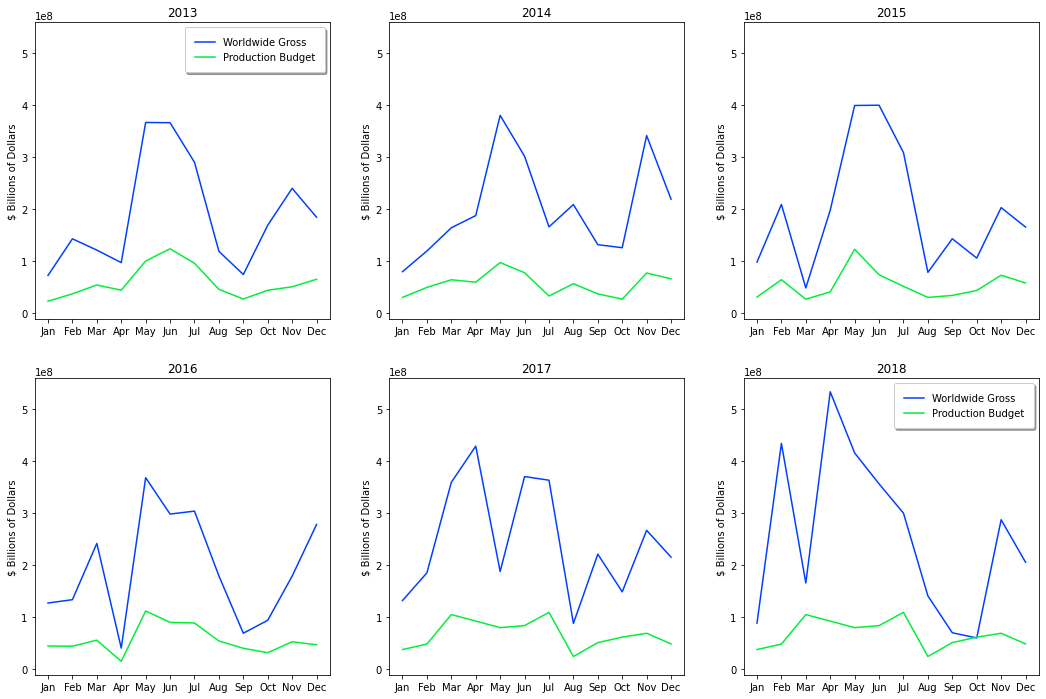

In [42]:
# Initialize 6 figures in one plot
# Set x to 'months' that we initialized above
# Plot each year
# Make them all share the same Y-axis
# Create a Legend for ease of reading

plt.style.use('seaborn-bright')
fig, ax = plt.subplots(2, 3, figsize = (18, 12))
x= months

ax[0,0].plot(x, mean_2013, label = 'Worldwide Gross')
ax[0,0].plot(x, mean_produc2013, label = 'Production Budget')
ax[0,0].set_title('2013')
ax[0,0].set_ylabel('$ Billions of Dollars')
ax[0,0].sharey(ax[1, 2])

ax[0,1].plot(x, mean_2014)
ax[0,1].plot(x, mean_produc2014)
ax[0,1].set_title('2014')
ax[0,1].set_ylabel('$ Billions of Dollars')
ax[0,1].sharey(ax[1, 2])

ax[0,2].plot(x, mean_2015)
ax[0,2].plot(x, mean_produc2015)
ax[0,2].set_title('2015')
ax[0,2].set_ylabel('$ Billions of Dollars')
ax[0,2].sharey(ax[1, 2])

ax[1,0].plot(x, mean_2016)
ax[1,0].plot(x, mean_produc2016)
ax[1,0].set_title('2016')
ax[1,0].set_ylabel('$ Billions of Dollars')
ax[1,0].sharey(ax[1, 2])

ax[1,1].plot(x, mean_2017)
ax[1,1].plot(x, mean_produc2017)
ax[1,1].set_title('2017')
ax[1,1].set_ylabel('$ Billions of Dollars')
ax[1,1].sharey(ax[1, 2])

ax[1,2].plot(x, mean_2018, label = 'Worldwide Gross')
ax[1,2].plot(x, mean_produc2017, label = 'Production Budget')
ax[1,2].set_title('2018')
ax[1,2].set_ylabel('$ Billions of Dollars');


ax[0,0].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
# ax[1,2].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

In [14]:
# Summer and holiday times are the ideal times to release our film. 
# Aug-Oct are the worst months to release a movie.

In [15]:
# Create a months dataframe to filter results per month

column_names = months
a = np.zeros(shape=(1,12), dtype = int)
df_months = pd.DataFrame(a, columns = column_names)

In [16]:
df_months_values = BigFrame

df_months_values['month'] = pd.Categorical(df_months_values['month'], categories=months, ordered=True)
df_months_values = df_months_values['month'].sort_values()
df_months_values = list(df_months_values)

for x in BigFrame['month']:
    if x in column_names:
        df_months[x] += 1
        
# Get the values from this function and copy them below *here*

list(df_months.value_counts().index)

[(69, 61, 81, 65, 68, 82, 82, 76, 83, 92, 106, 102)]

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


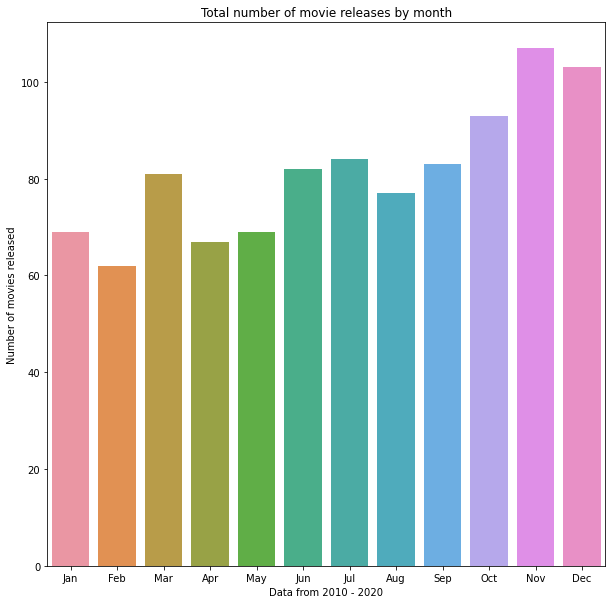

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-bright')
fig, ax = plt.subplots(figsize = (10, 10))
x = months
#y = [*here*]
y = [69, 62, 81, 67, 69, 82, 84, 77, 83, 93, 107, 103]
sns.barplot(x, y);
ax.set_title('Total number of movie releases by month')
ax.set_xlabel('Data from 2010 - 2020')
ax.set_ylabel('Number of movies released');

In [18]:
# The best window to release our blockbuster action / drama/ suspense film is releasing during the summer months or holiday season
# This distribution shows that more movie production companies release later in the year.
# Therefore, we can conclude that it is best to release our movie in either May or June. 